# Projet : Analyse de l'Insertion des Diplômés de Master

1. Présentation du Dataset Dans le cadre du module AAS, nous analysons le jeu de données "Insertion professionnelle des diplômés de Master" (source : data.gouv.fr). Ce dataset recense les indicateurs d'emploi (taux d'insertion, salaires) des diplômés universitaires en France, agrégés par établissement, discipline et année.

2. Objectif et Tâche ML L'objectif est d'identifier les facteurs déterminants de l'employabilité des jeunes diplômés.

Nous formulons ce problème comme une tâche de Régression :

Variable Cible (Target) : taux_dinsertion (le pourcentage de diplômés ayant un emploi).

Démarche : Le projet suivra un pipeline complet : nettoyage des données, exploration visuelle (EDA) et modélisation prédictive.

On va supprimer toutes les lignes ou le taux d'insertions n'est pas donner 

# 1.Nettoyage

## 1.1 importations du dataset

In [9]:
import numpy as np
import pandas as pd
df = pd.read_csv('fr-esr-insertion_professionnelle-master.csv', sep=';')
df.head()

,annee,diplome,numero_de_l_etablissement,etablissement,etablissementactuel,code_de_l_academie,academie,code_du_domaine,domaine,code_de_la_discipline,...,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile,cle_etab,cle_disc,id_paysage
0,2012,MASTER LMD,0681166Y,Mulhouse - Haute Alsace,NaN,A15,Strasbourg,STS,"Sciences, technologies et santé",disc15,...,9.3,1760,ns,ns,ns,1430,2080,Mulhouse - Haute Alsace_18,disc15_18,OJZ4a
1,2012,MASTER LMD,0691775E,Lyon 2 - Lumière,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc09,...,8.9,1780,81,29,83,1430,2130,Lyon 2 - Lumière_18,disc09_18,CUBKB
2,2012,MASTER LMD,0692437Z,Lyon 3 - Jean Moulin,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc11,...,8.9,1780,45,41,57,1430,2130,Lyon 3 - Jean Moulin_18,disc11_18,7Gzub
3,2012,MASTER LMD,0730858L,Savoie Mont Blanc,NaN,A08,Grenoble,DEG,"Droit, économie et gestion",disc01,...,8.9,1780,30,46,66,1430,2130,Savoie Mont Blanc_18,disc01_18,zCa4j
4,2012,MASTER LMD,0750736T,Paris - Dauphine,NaN,A01,Paris,DEG,"Droit, économie et gestion",disc04,...,9,2020,NaN,NaN,NaN,1580,2530,Paris - Dauphine_18,disc04_18,C6Ps7


## 1.2 SUPPRESSION DES NS.
On supprime les ns par la moyenne trouver qui correspond a la discipline sciences de l'ingenieur et les ns qui correspondes au emplois_cadre_ou_professions_intermediaires.

In [10]:
df_clean = df.copy()
# Liste des valeurs considérées comme manquantes
missing_vals = ["ns", "nd", "", " "]

limit = len(df) * 0.5
df_clean = df.dropna(thresh=limit, axis=1).copy()

# Convertir "ns" en NaN dans la colonne ciblée
df_clean["emplois_cadre_ou_professions_intermediaires"] = pd.to_numeric(
    df_clean["emplois_cadre_ou_professions_intermediaires"].replace(missing_vals, pd.NA),
    errors="coerce"
)

# Filtrer exactement la discipline Sciences de l'ingénieur
mask_disc = df_clean["discipline"] == "Sciences de l'ingénieur"

# Calculer la moyenne uniquement pour cette discipline
moyenne_si = df_clean.loc[mask_disc, "emplois_cadre_ou_professions_intermediaires"].mean()

print("Moyenne pour science de l'ingénieur :", moyenne_si)

# Remplacer les NaN (ex-ns) uniquement pour cette discipline
df_clean.loc[
    mask_disc & df_clean["emplois_cadre_ou_professions_intermediaires"].isna(),
    "emplois_cadre_ou_professions_intermediaires"
] = moyenne_si

# Convertir en numérique (tout ce qui n'est pas un nombre devient NaN)
df_clean["taux_dinsertion"] = pd.to_numeric(df_clean["taux_dinsertion"], errors="coerce")

# Garder uniquement les lignes avec un vrai nombre
df_clean = df_clean[df_clean["taux_dinsertion"].notna()]

print(f"avant nettoyage : {len(df_clean)} lignes")

df_clean = df_clean.replace(missing_vals, pd.NA)
# Nombre de colonnes du fichier
n_cols = len(df_clean.columns)

# Condition : une ligne est supprimée si elle contient >= 1/3 de NaN
df_clean = df_clean[df_clean.isna().sum(axis=1) < (n_cols / 3)]

print(f"Lignes avant : {len(df)} -> Lignes après nettoyage : {len(df_clean)}")









Moyenne pour science de l'ingénieur : 97.26666666666667
avant nettoyage : 10856 lignes
Lignes avant : 19603 -> Lignes après nettoyage : 10843


## 1.3 On utilises une methode qu'on appele IQR pour detecter les outliers(si x < Q1 - 5*IQR ou x > Q3 + 5*IQR)



In [11]:
"""colonnes_numeriques = ["nombre_de_reponses",
                       "taux_de_reponse",
                       "poids_de_la_discipline",
                       "taux_dinsertion",
                       "emplois_cadre_ou_professions_intermediaires",
                       "emplois_stables",
                       "emplois_a_temps_plein",
                       "salaire_net_median_des_emplois_a_temps_plein",
                       "salaire_brut_annuel_estime",
                       "de_diplomes_boursiers",
                       "taux_de_chomage_regional",
                       "salaire_net_mensuel_median_regional",
                       "emplois_cadre",
                       "emplois_exterieurs_a_la_region_de_luniversite",
                       "femmes",
                       "salaire_net_mensuel_regional_1er_quartile",
                       "salaire_net_mensuel_regional_3eme_quartile",
                       "annee"] 

df_clean = df.copy()

for col in colonnes_numeriques:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

for col in colonnes_numeriques:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    borne_basse = Q1 - 5 * IQR
    borne_haute = Q3 + 5 * IQR

    df_clean = df_clean[
        (df_clean[col] >= borne_basse) & (df_clean[col] <= borne_haute)
    ]

print(f"Lignes après nettoyage : {len(df_clean)}")
#df_clean.to_csv("fr-esr-cleaned.csv", sep=";", index=False)"""


'colonnes_numeriques = ["nombre_de_reponses",\n                       "taux_de_reponse",\n                       "poids_de_la_discipline",\n                       "taux_dinsertion",\n                       "emplois_cadre_ou_professions_intermediaires",\n                       "emplois_stables",\n                       "emplois_a_temps_plein",\n                       "salaire_net_median_des_emplois_a_temps_plein",\n                       "salaire_brut_annuel_estime",\n                       "de_diplomes_boursiers",\n                       "taux_de_chomage_regional",\n                       "salaire_net_mensuel_median_regional",\n                       "emplois_cadre",\n                       "emplois_exterieurs_a_la_region_de_luniversite",\n                       "femmes",\n                       "salaire_net_mensuel_regional_1er_quartile",\n                       "salaire_net_mensuel_regional_3eme_quartile",\n                       "annee"] \n\ndf_clean = df.copy()\n\nfor col in colonn

## 1.3 CONVERSION DES CHIFFRES
Par sécurité, on force la conversion des colonnes importantes en numérique


In [12]:
cols_to_fix = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']
for col in cols_to_fix:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

## 1.4 NETTOYAGE DES LIGNES
On supprime les lignes où l'info cruciale 'taux_dinsertion' est manquante

In [13]:
target_col = 'taux_dinsertion'
df_clean = df_clean.dropna(subset=[target_col])

## 1.5 IMPUTATION DES VARIABLES EXPLICATIVES (FEATURES)
 Pour ne pas perdre d'info, on remplit les trous des autres colonnes numériques (ex: salaire) par la médiane

In [14]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != target_col: # On ne touche pas à la target car on l'a déjà nettoyée
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

## 1.6 Resultat

In [15]:
print(f"Lignes avant : {len(df)} -> Lignes après nettoyage : {len(df_clean)}")
df_clean.head()

Lignes avant : 19603 -> Lignes après nettoyage : 10843


,annee,diplome,numero_de_l_etablissement,etablissement,code_de_l_academie,academie,code_du_domaine,domaine,code_de_la_discipline,discipline,...,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile,cle_etab,cle_disc,id_paysage
1,2012,MASTER LMD,0691775E,Lyon 2 - Lumière,A10,Lyon,SHS,Sciences humaines et sociales,disc09,Psychologie,...,8.9,1780,81,29,83,1430,2130,Lyon 2 - Lumière_18,disc09_18,CUBKB
2,2012,MASTER LMD,0692437Z,Lyon 3 - Jean Moulin,A10,Lyon,SHS,Sciences humaines et sociales,disc11,Autres sciences humaines et sociales,...,8.9,1780,45,41,57,1430,2130,Lyon 3 - Jean Moulin_18,disc11_18,7Gzub
3,2012,MASTER LMD,0730858L,Savoie Mont Blanc,A08,Grenoble,DEG,"Droit, économie et gestion",disc01,"Ensemble formations juridiques, économiques et...",...,8.9,1780,30,46,66,1430,2130,Savoie Mont Blanc_18,disc01_18,zCa4j
5,2012,MASTER LMD,0751717J,Paris 1 - Panthéon Sorbonne,A01,Paris,STS,"Sciences, technologies et santé",disc12,"Ensemble sciences, technologies et santé",...,9,2020,<NA>,<NA>,<NA>,1580,2530,Paris 1 - Panthéon Sorbonne_30,disc12_30,6G2TU
10,2012,MASTER LMD,0830766G,Toulon,A23,Nice,DEG,"Droit, économie et gestion",disc01,"Ensemble formations juridiques, économiques et...",...,11.7,1790,21,23,74,1390,2170,Toulon_18,disc01_18,C701f


# 2. EDA

In [16]:
import matplotlib.pyplot as plt # Pour la visualisation (impliqué par les graphiques du cours)
import seaborn as sns # Souvent utilisé avec pandas pour les heatmaps

# Statistiques descriptives globales
print(df_clean.describe())

              annee  nombre_de_reponses  taux_dinsertion  \
count  10843.000000        10843.000000     10843.000000   
mean    2015.409112          220.223554        89.831781   
std        2.963020          833.419504         6.644011   
min     2010.000000           24.000000         6.000000   
25%     2013.000000           45.000000        86.000000   
50%     2015.000000           75.000000        91.000000   
75%     2018.000000          138.000000        95.000000   
max     2020.000000        13587.000000       100.000000   

       emplois_cadre_ou_professions_intermediaires  \
count                                 10843.000000   
mean                                     87.548575   
std                                      10.117397   
min                                       3.000000   
25%                                      83.000000   
50%                                      90.000000   
75%                                      95.000000   
max                        

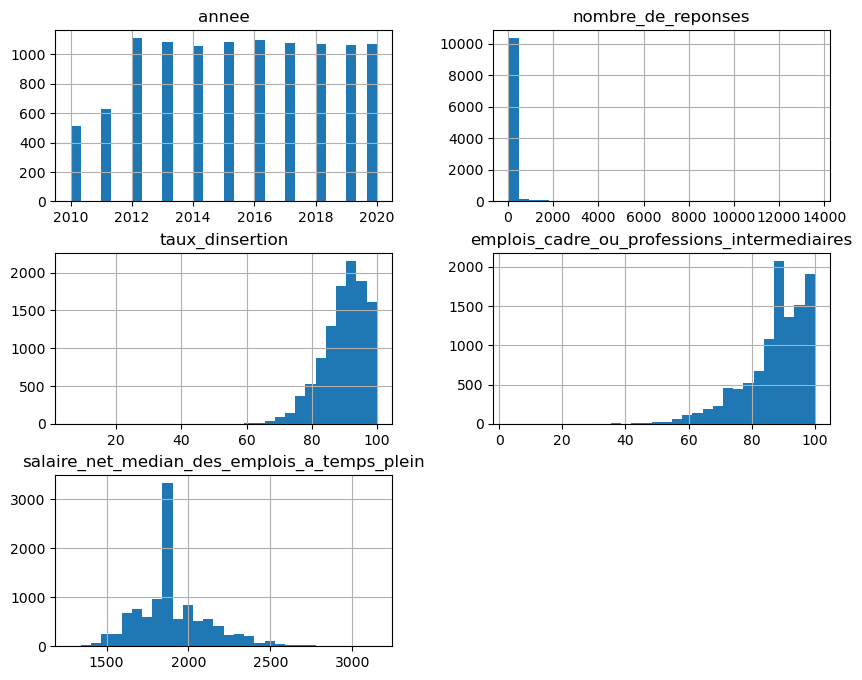

In [17]:
# Visualisation des distributions (Histogrammes)
# Pour voir la forme (normale, asymétrique...)
df_clean.hist(figsize=(10, 8), bins=30)
plt.show()

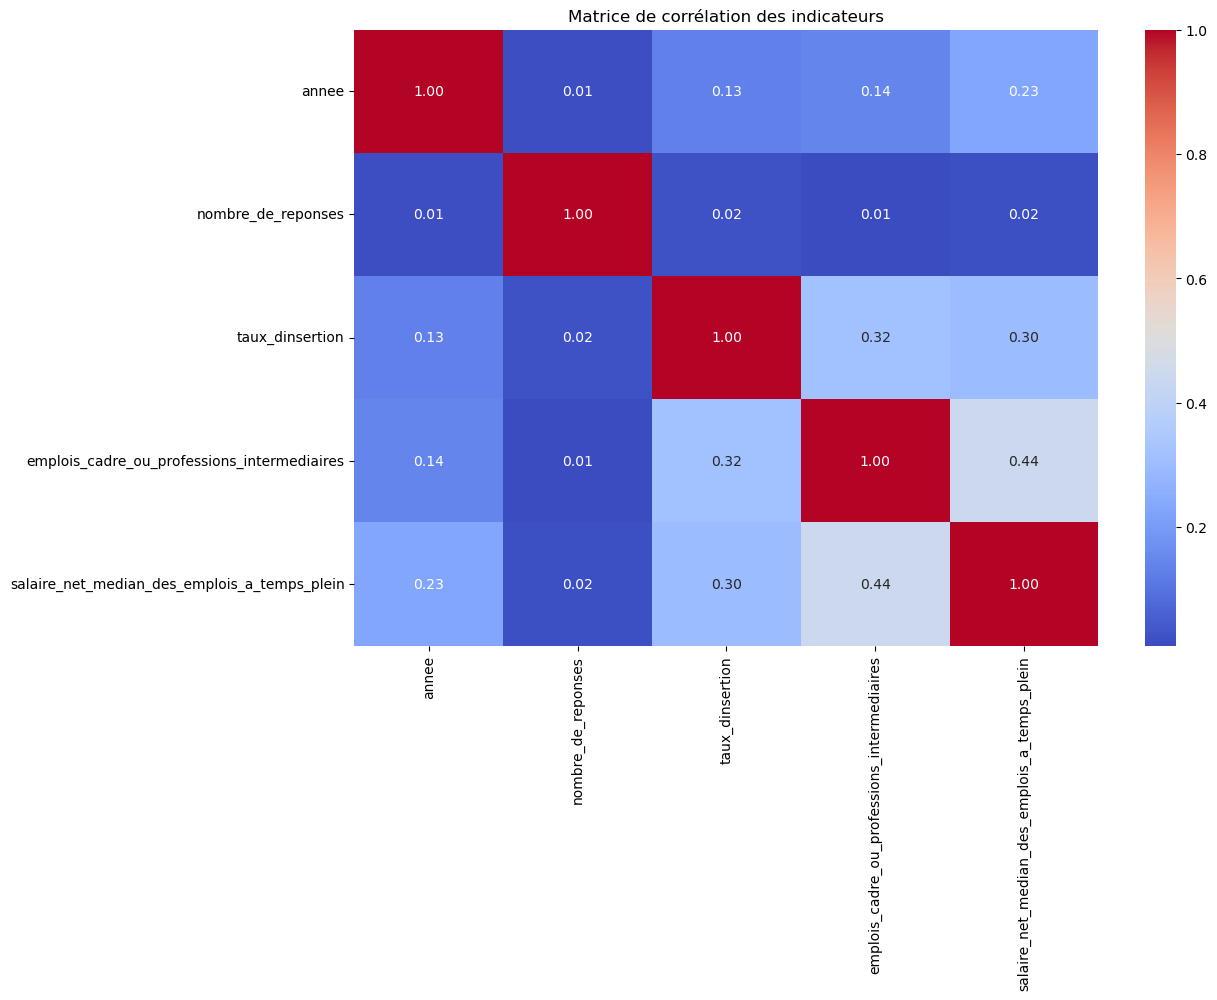

In [18]:
# Calcul de la corrélation
plt.figure(figsize=(12, 8))
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des indicateurs")
plt.show()

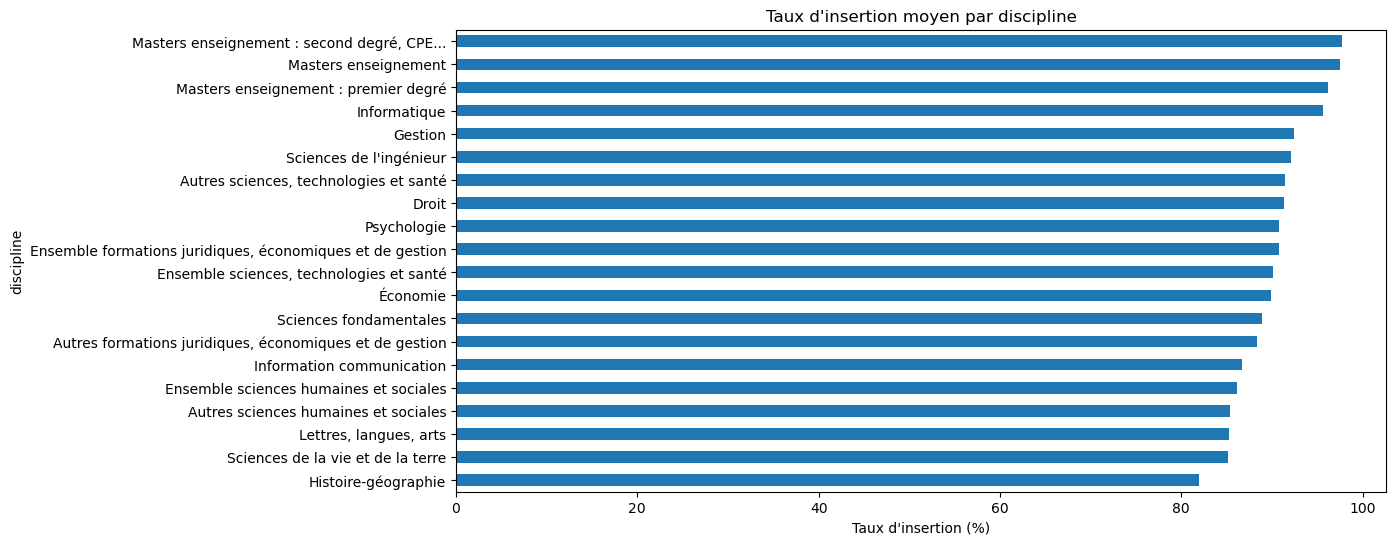

In [19]:
# Taux d'insertion moyen par discipline
plt.figure(figsize=(12, 6))
df_clean.groupby('discipline')['taux_dinsertion'].mean().sort_values().plot(kind='barh')
plt.title("Taux d'insertion moyen par discipline")
plt.xlabel("Taux d'insertion (%)")
plt.show()

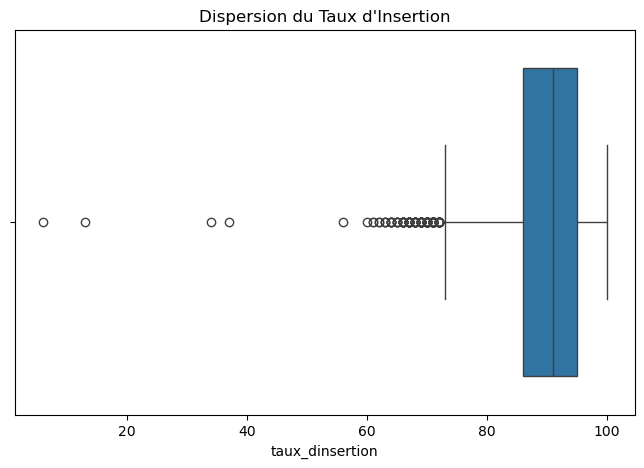

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clean['taux_dinsertion'])
plt.title("Dispersion du Taux d'Insertion")
plt.show()